In [1]:
from sqlalchemy import create_engine
import pandas as pd

from paths import HERE

DB_PATH = HERE.joinpath('experiment_results.db').as_posix()
conn = create_engine(f'sqlite:///{DB_PATH}')


In [25]:
query = """
select model_scores,
       group_key,
       couple_tpr,
       couple_fpr,
       group_size,
       nb_attributes,
       nb_groups,
       granularity,
       intersectionality,
       1 - similarity as similarity,
       alea_uncertainty                                             as alea_uncertainty,
       epis_uncertainty                                             as epis_uncertainty,
       magnitude,
       frequency,
       count(CASE WHEN diff_outcome_y IS NOT NULL THEN 1 ELSE NULL END) as number_of_found_cases
from results4
group by model_scores,
         group_key
order by number_of_found_cases DESC;
"""

df = pd.read_sql_query(query, conn)
df

,model_scores,group_key,couple_tpr,couple_fpr,group_size,nb_attributes,nb_groups,granularity,intersectionality,similarity,alea_uncertainty,epis_uncertainty,magnitude,frequency,number_of_found_cases
0,"{'model': 'RandomForestClassifier', 'score': 0...",1|0|2|1*1|2|2|1,0.002366,0.750000,28.0,4.0,516.0,3.0,1.0,0.879924,0.463923,0.973829,0.292693,0.999565,384
1,"{'model': 'RandomForestClassifier', 'score': 0...",1|1|1|1*1|1|0|1,0.003902,0.250000,24.0,4.0,164.0,3.0,1.0,0.868653,0.579303,0.892547,0.544304,0.779111,240
2,"{'model': 'DecisionTreeClassifier', 'score': 0...",3|1|2|1*3|1|2|2,0.015135,0.223502,33.0,4.0,598.0,2.0,2.0,0.800461,0.209934,0.330818,0.974439,0.977770,232
3,"{'model': 'MLPClassifier', 'score': 0.66367346...",1|1|3*0|1|3,0.012100,0.233333,20.0,3.0,292.0,1.0,2.0,0.723182,0.381813,0.193133,0.648570,0.557840,204
4,"{'model': 'MLPClassifier', 'score': 0.66367346...",1|0|2*2|0|2,0.012100,0.233333,19.0,3.0,292.0,1.0,2.0,0.718322,0.200256,0.192142,0.660909,0.520177,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133689,"{'model': 'SVC', 'score': 0.9971264367816092, ...",3|3|1|1*3|0|2|0,0.000000,0.000000,33.0,4.0,270.0,3.0,1.0,0.404098,0.996821,0.536903,0.668814,0.992890,0
133690,"{'model': 'SVC', 'score': 0.9971264367816092, ...",3|3|1|2*0|2|1|3,0.000000,0.000000,33.0,4.0,270.0,3.0,1.0,0.532474,0.996204,0.487189,0.734591,0.988689,0
133691,"{'model': 'SVC', 'score': 0.9971264367816092, ...",3|3|1|3*0|3|2|1,0.000000,0.000000,33.0,4.0,270.0,3.0,1.0,0.330557,0.996818,0.430035,0.303583,0.986345,0
133692,"{'model': 'SVC', 'score': 0.9971264367816092, ...",3|3|2|0*1|3|2|1,0.000000,0.000000,33.0,4.0,270.0,3.0,1.0,0.626087,0.997044,0.391657,0.558089,0.991008,0


In [26]:
import json
df['model_type'] = df['model_scores'].apply(lambda x:json.loads(x.replace("\'", "\""))['model'] if isinstance(x, str) else x)
df['mod_score'] = df['model_scores'].apply(lambda x:json.loads(x.replace("\'", "\""))['f1_score'] if isinstance(x, str) else x)


In [29]:
# Assuming df is predefined and already imported
dff = df[df['number_of_found_cases']>20]


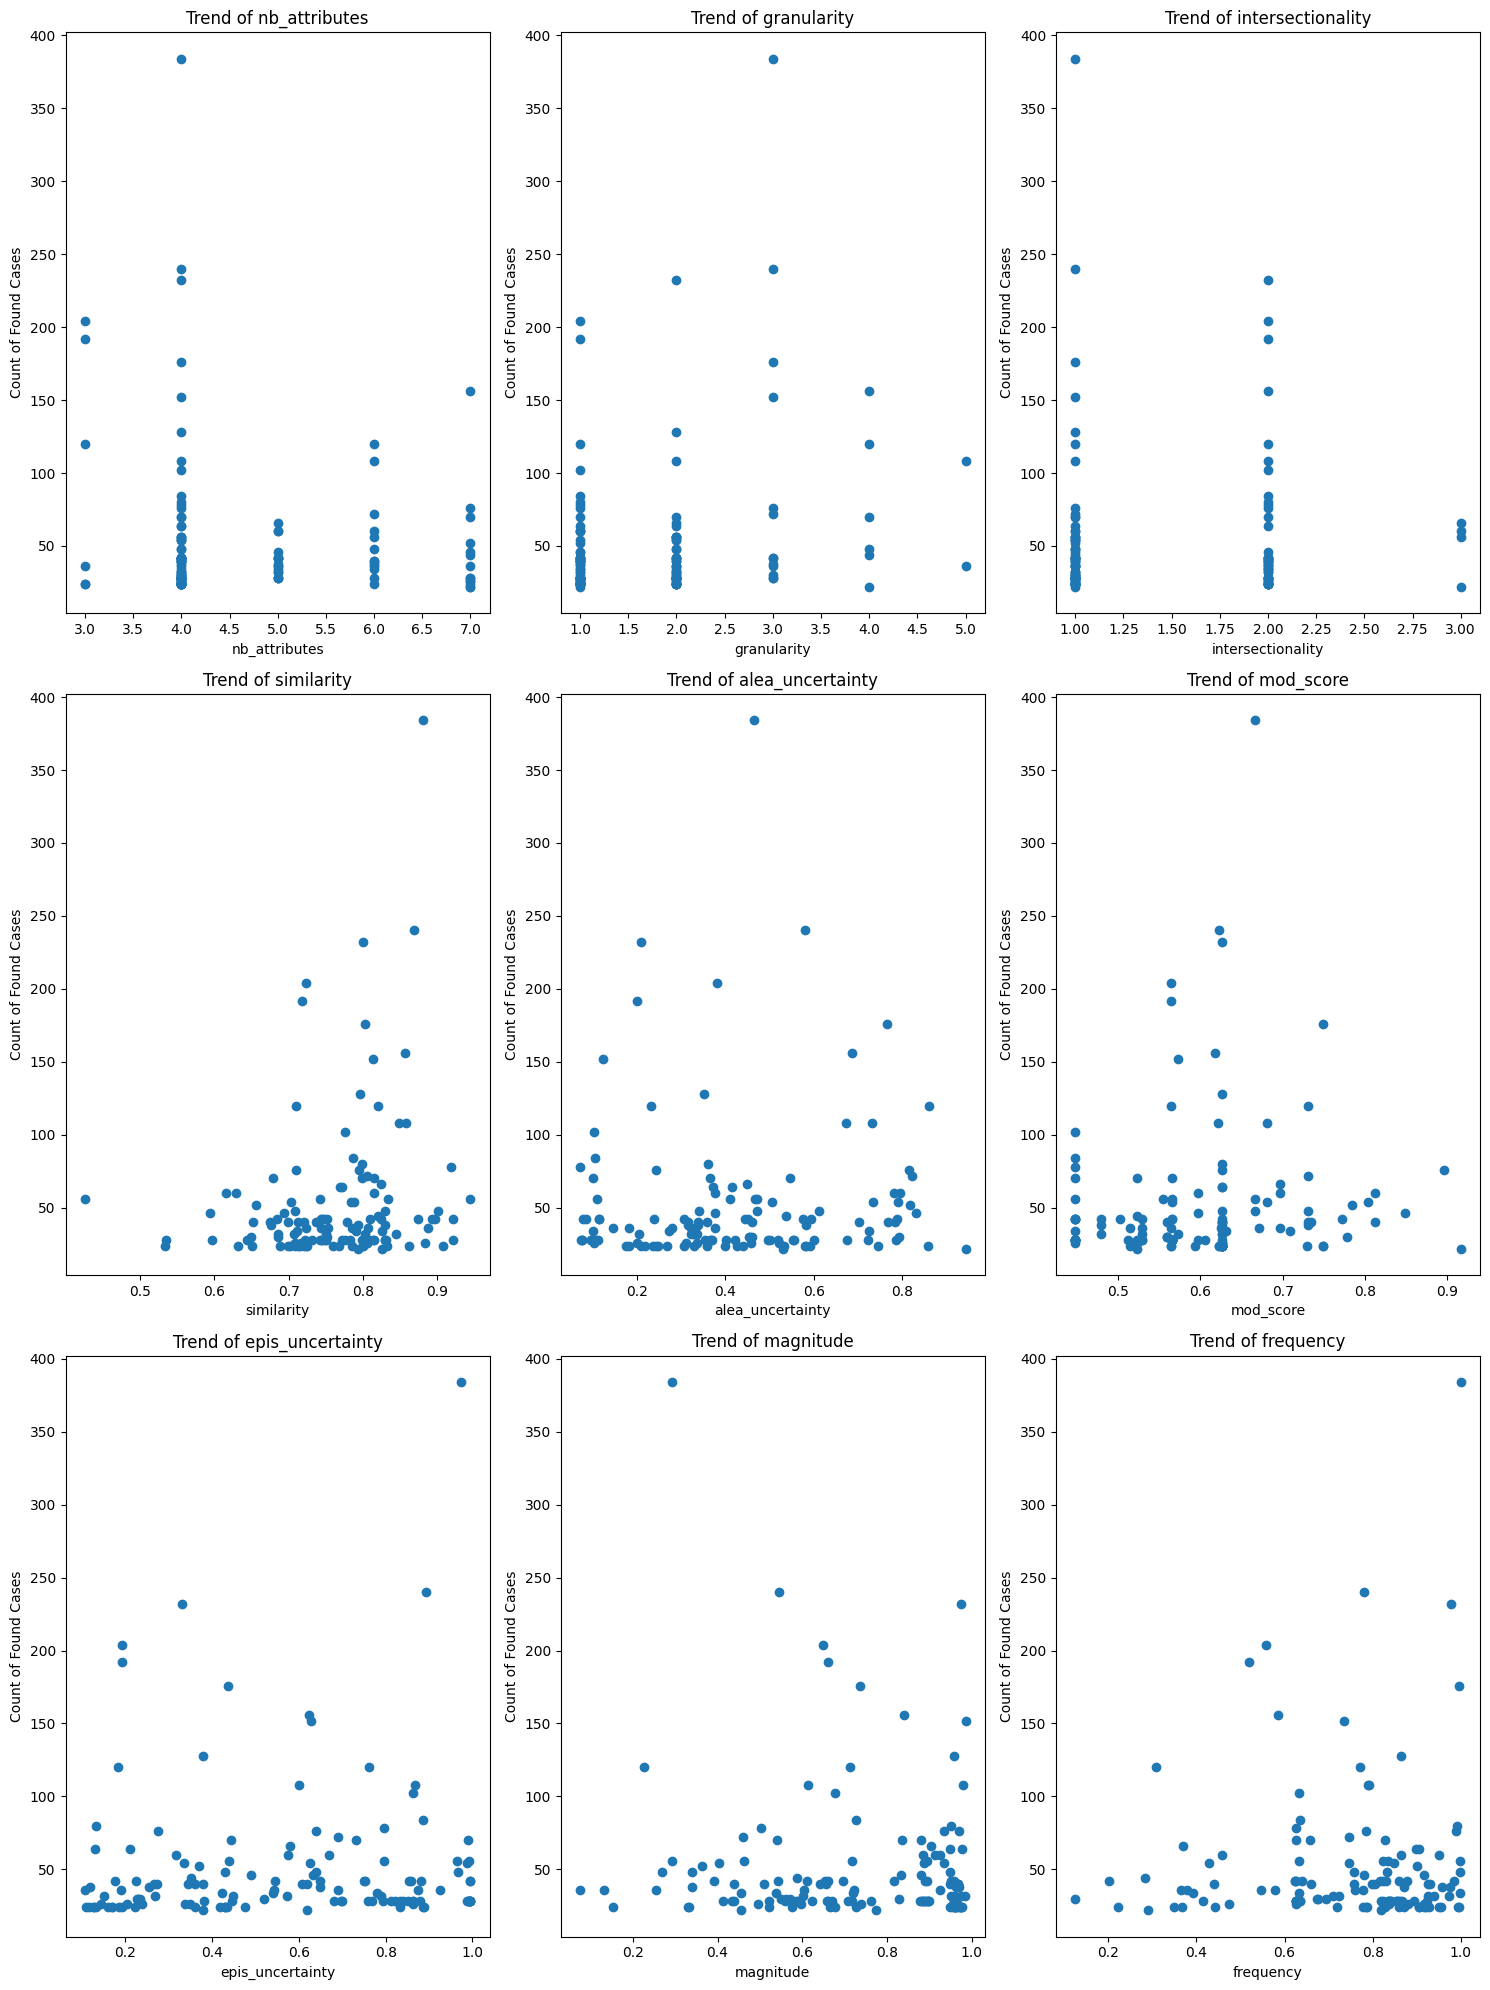

In [30]:

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))
axes = axes.flatten()
properties = [
    'nb_attributes', 'granularity', 'intersectionality', 'similarity', 'alea_uncertainty', 'mod_score',
    'epis_uncertainty', 'magnitude', 'frequency'
]

for i, prop in enumerate(properties):
    axes[i].scatter(dff[prop], dff['number_of_found_cases'])
    axes[i].set_title(f'Trend of {prop}')
    axes[i].set_xlabel(prop)
    axes[i].set_ylabel('Count of Found Cases')

plt.tight_layout()
plt.savefig('figuree1.png')
plt.show()

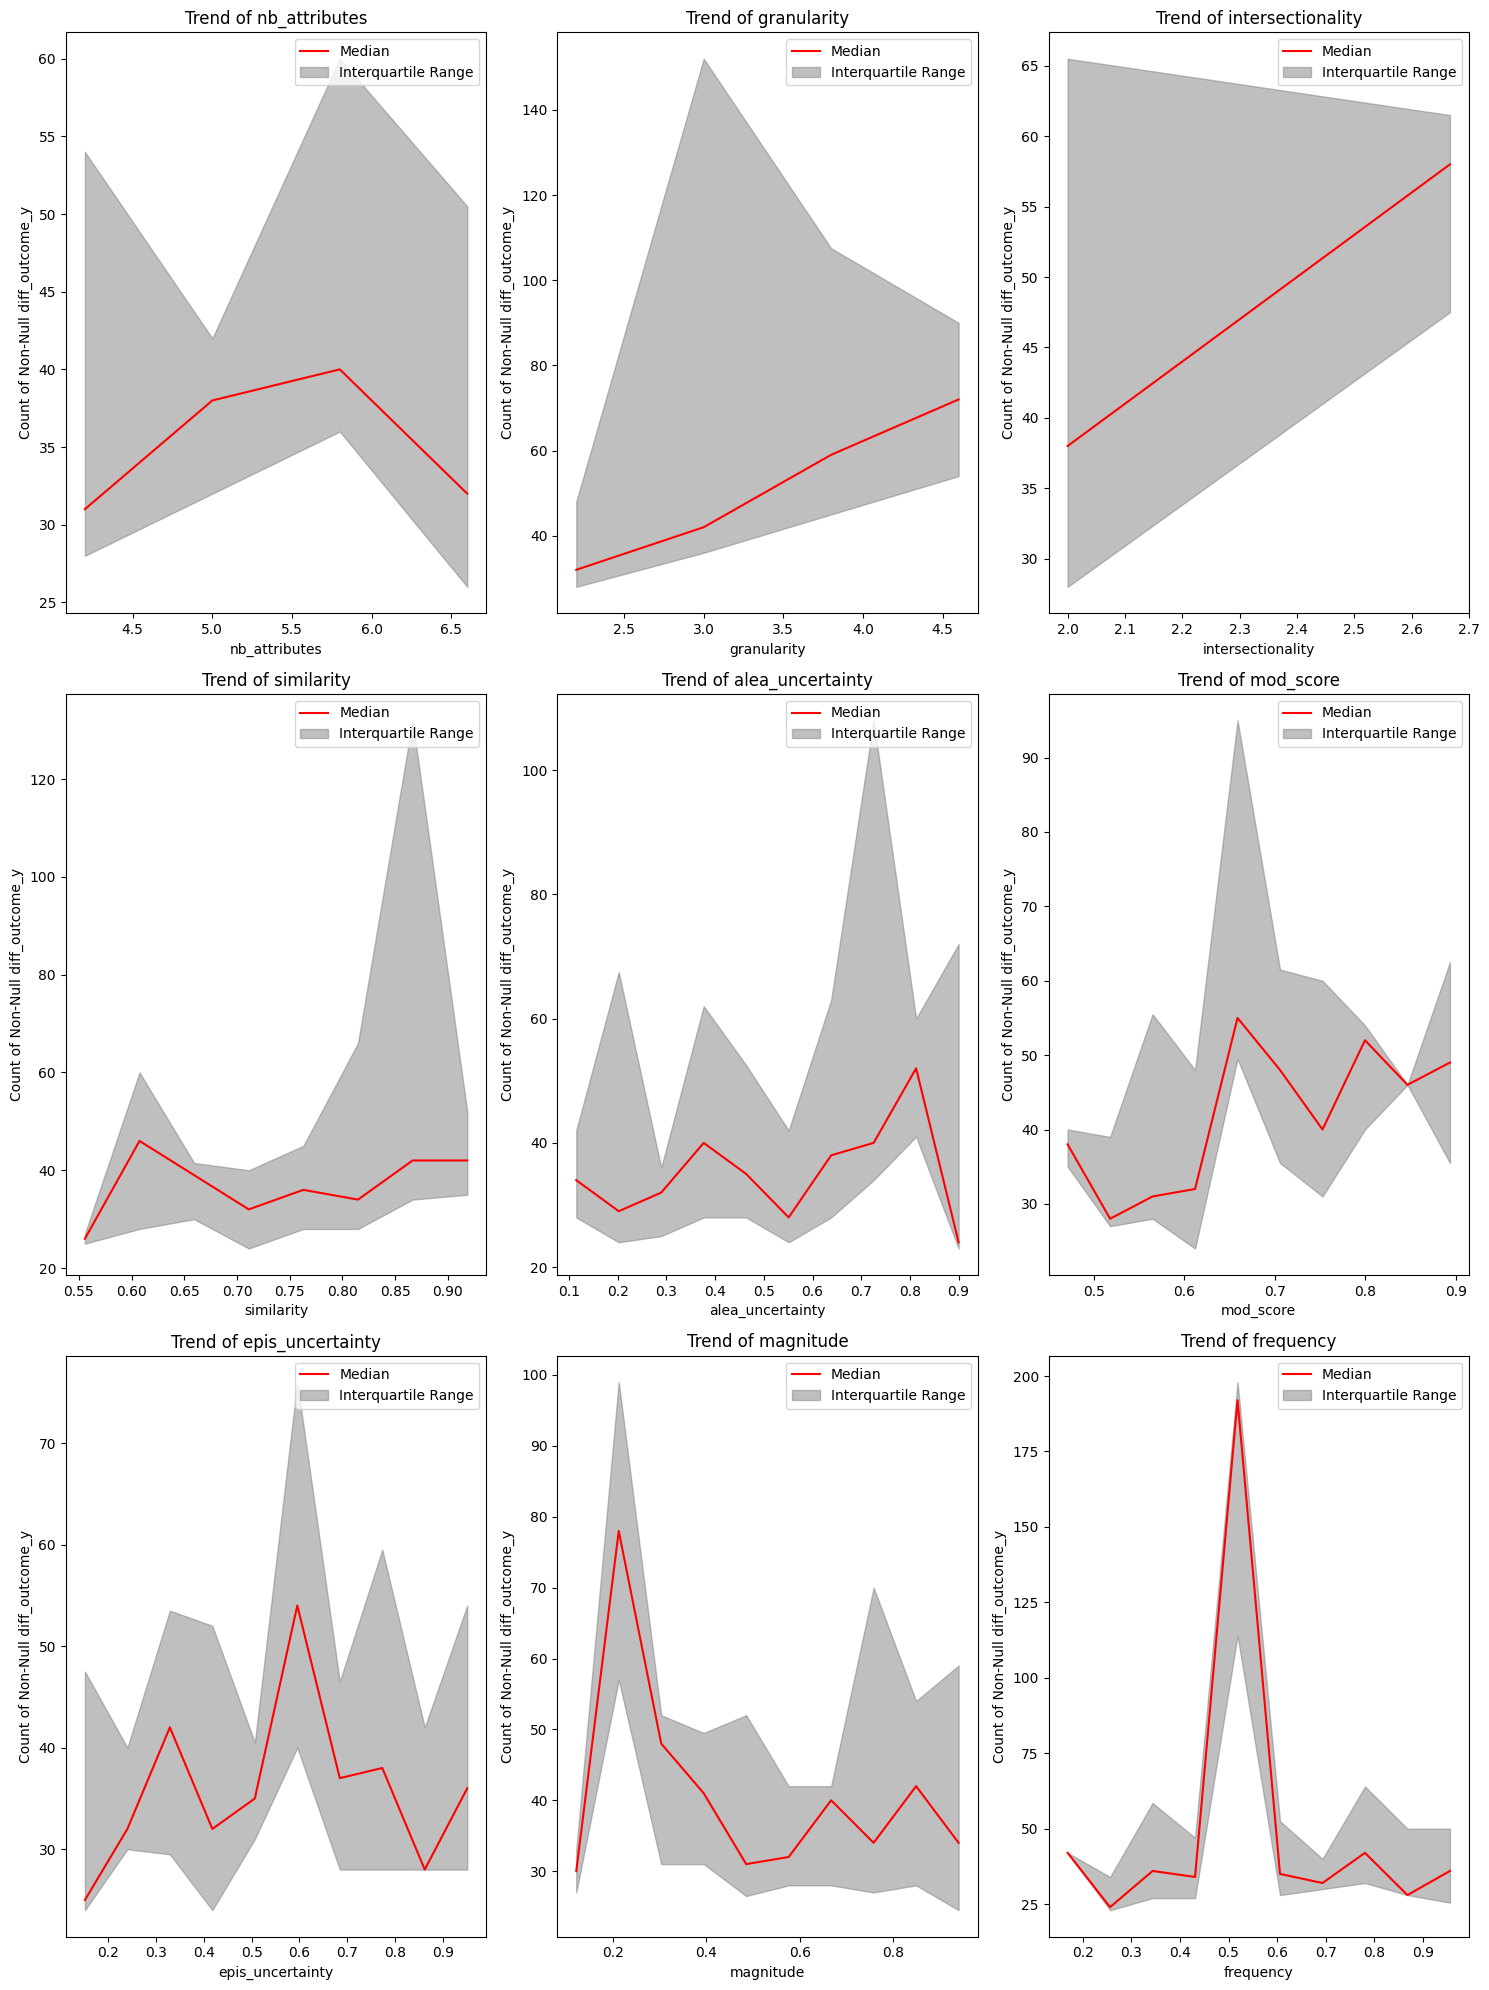

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def bin_and_statistics(data, k):
    if data.shape[1] != 2:
        raise ValueError("Data must be a 2-dimensional array with shape (N, 2)")

    # Dynamically set k based on the unique values in the property
    unique_values = len(np.unique(data[:, 0]))
    k = min(k, unique_values)
    if k < 1:
        k = 1  # Ensure at least one bin

    min_val = np.min(data[:, 0])
    max_val = np.max(data[:, 0])
    
    bins = np.linspace(min_val, max_val, k + 1)
    bin_indices = np.digitize(data[:, 0], bins, right=True)
    
    # Statistics arrays
    medians = np.zeros(k)
    first_quartiles = np.zeros(k)
    third_quartiles = np.zeros(k)
    
    for i in range(1, k + 1):
        bin_elements = data[bin_indices == i, 1]
        
        if bin_elements.size > 0:
            medians[i - 1] = np.median(bin_elements)
            first_quartiles[i - 1] = np.percentile(bin_elements, 25)
            third_quartiles[i - 1] = np.percentile(bin_elements, 75)
        else:
            medians[i - 1] = np.nan  # Use NaN for empty bins
            first_quartiles[i - 1] = np.nan
            third_quartiles[i - 1] = np.nan

    return bins, medians, first_quartiles, third_quartiles

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))
axes = axes.flatten()

properties = [
    'nb_attributes',
    'granularity', 'intersectionality', 'similarity', 'alea_uncertainty', 'mod_score',
    'epis_uncertainty', 'magnitude', 'frequency'
]

for i, prop in enumerate(properties):
    if pd.api.types.is_numeric_dtype(dff[prop]):  # Check if the property is numeric
        data = dff[[prop, 'number_of_found_cases']].dropna().to_numpy()
        if data.size == 0:
            continue  # Skip if no data to plot
        bins, medians, first_quartiles, third_quartiles = bin_and_statistics(data, 10)
        bin_midpoints = (bins[:-1] + bins[1:]) / 2

        # Plotting median line
        axes[i].plot(bin_midpoints, medians, color='red', label='Median')
        # Plotting the uncertainty area between the first and third quartiles
        axes[i].fill_between(bin_midpoints, first_quartiles, third_quartiles, color='gray', alpha=0.5, label='Interquartile Range')

        axes[i].set_title(f'Trend of {prop}')
        axes[i].set_xlabel(prop)
        axes[i].set_ylabel('Count of Non-Null diff_outcome_y')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'Non-numeric data: {prop}', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Trend of {prop}')

plt.tight_layout()
plt.savefig('figuree2.png')
plt.show()


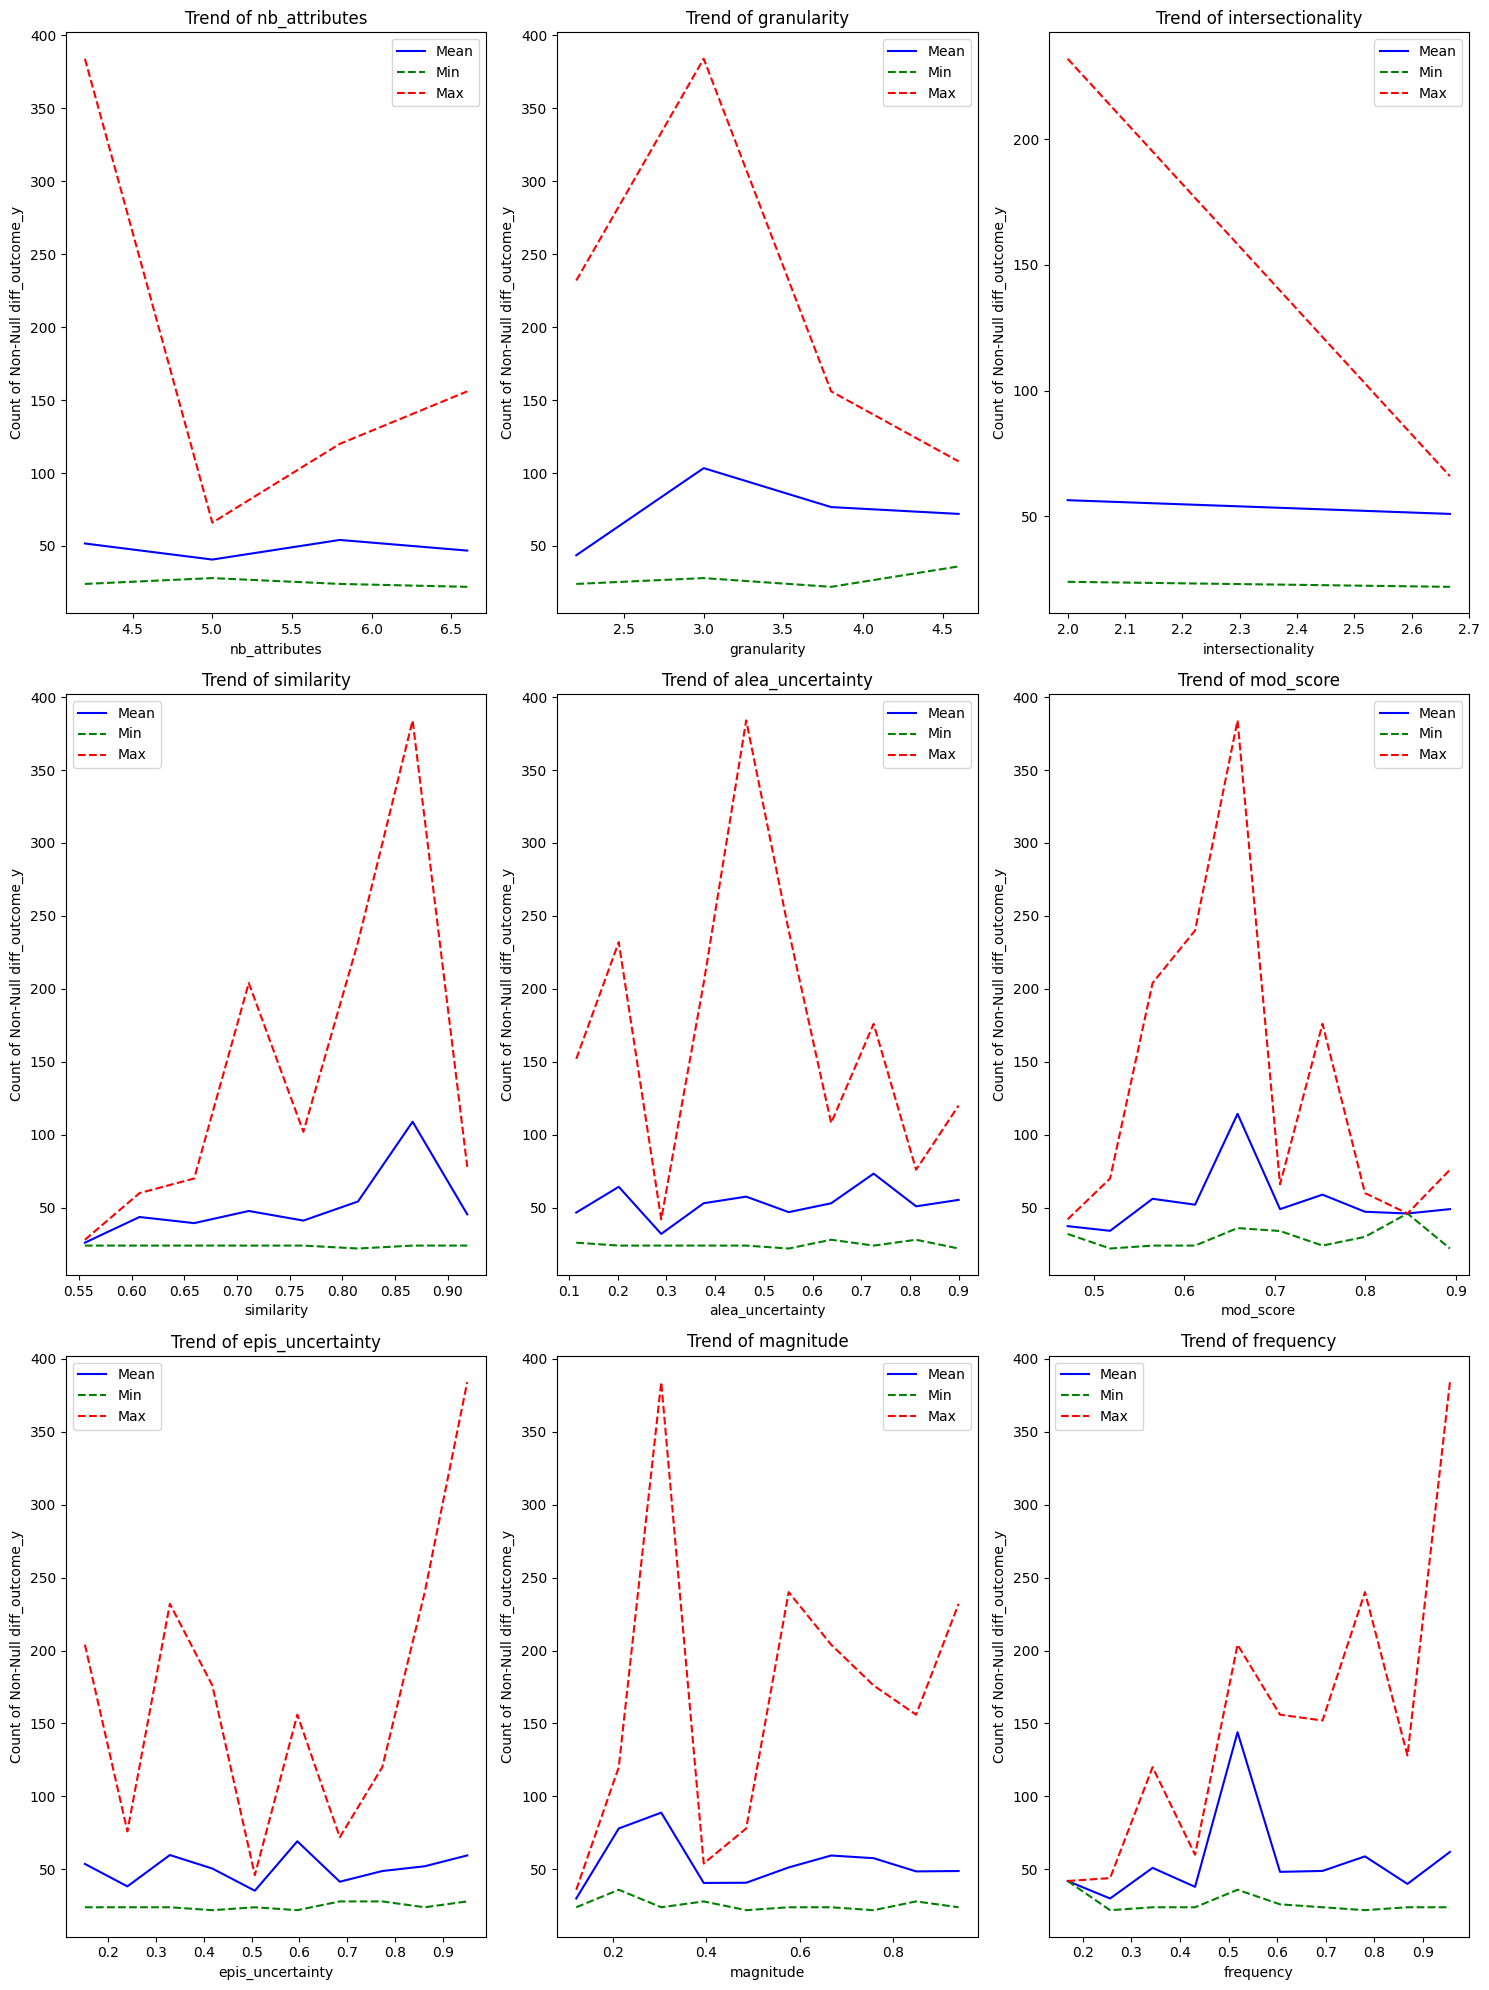

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def bin_and_statistics(data, k):
    if data.shape[1] != 2:
        raise ValueError("Data must be a 2-dimensional array with shape (N, 2)")

    unique_values = len(np.unique(data[:, 0]))
    k = min(k, unique_values)
    if k < 1:
        k = 1  # Ensure at least one bin

    min_val = np.min(data[:, 0])
    max_val = np.max(data[:, 0])
    
    bins = np.linspace(min_val, max_val, k + 1)
    bin_indices = np.digitize(data[:, 0], bins, right=True)
    
    # Statistics arrays
    means = np.zeros(k)
    mins = np.zeros(k)
    maxs = np.zeros(k)
    
    for i in range(1, k + 1):
        bin_elements = data[bin_indices == i, 1]
        
        if bin_elements.size > 0:
            means[i - 1] = np.mean(bin_elements)
            mins[i - 1] = np.min(bin_elements)
            maxs[i - 1] = np.max(bin_elements)
        else:
            means[i - 1] = np.nan  # Use NaN for empty bins
            mins[i - 1] = np.nan
            maxs[i - 1] = np.nan

    return bins, mins, means, maxs

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 20))
axes = axes.flatten()

properties = [
    'nb_attributes', 'granularity', 'intersectionality', 'similarity',
    'alea_uncertainty', 'mod_score', 'epis_uncertainty', 'magnitude', 'frequency'
]

for i, prop in enumerate(properties):
    if pd.api.types.is_numeric_dtype(dff[prop]):
        data = dff[[prop, 'number_of_found_cases']].dropna().to_numpy()
        if data.size == 0:
            continue
        bins, mins, means, maxs = bin_and_statistics(data, 10)
        bin_midpoints = (bins[:-1] + bins[1:]) / 2

        # Plotting mean line
        axes[i].plot(bin_midpoints, means, color='blue', label='Mean')
        # Plotting min and max lines
        axes[i].plot(bin_midpoints, mins, color='green', linestyle='--', label='Min')
        axes[i].plot(bin_midpoints, maxs, color='red', linestyle='--', label='Max')

        axes[i].set_title(f'Trend of {prop}')
        axes[i].set_xlabel(prop)
        axes[i].set_ylabel('Count of Non-Null diff_outcome_y')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'Non-numeric data: {prop}', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Trend of {prop}')

plt.tight_layout()
plt.savefig('updated_figure.png')
plt.show()
